## Uncertainty Estimates from Classifiers

Another useful part of the scikit-learn interface that we haven’t talked about yet is the ability of classifiers to provide uncertainty estimates of predictions. Often, you are not only interested in which class a classifier predicts for a certain test point, but also how certain it is that this is the right class. 

In practice, different kinds of mistakes lead to very different outcomes in real-world applications. Imagine a medical application testing for cancer. Making a false positive prediction might lead to a patient undergoing additional tests, while a false negative prediction might lead to a serious disease not being treated.

There are two different functions in scikit-learn that can be used to obtain uncertainty estimates from classifiers: *decision_function* and *predict_proba*. Most (but not all) classifiers have at least one of them, and many classifiers have both. 

Let’s look at what these two functions do on a synthetic two-dimensional dataset, when building a *GradientBoostingClassifier* classifier, which has both a *decision_function* and a *predict_proba* method.

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn
from IPython.display import display
import mglearn

# Don't display deprecation warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_circles

X, y = make_circles(noise=0.25, factor=0.5, random_state=1)

# We rename the classes "blue" and "red" for illustration purposes
y_named = np.array(["blue", "red"])[y]

# We can call train_test_split with arbitrarily many arrays;
# All will be split in a consistent manner
X_train, X_test, y_train_named, y_test_named, y_train, y_test = train_test_split(X, y_named, y, random_state=0)

# Build the gradient boosting model
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train_named)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

### The Decision Function

In the binary classification case, the return value of *decision_function* is of shape (*n_samples*,), and it returns one floating point number for each sample.

In [4]:
print("X_test.shape: {}".format(X_test.shape))
print("Decision function shape: {}".format(gbrt.decision_function(X_test).shape))

X_test.shape: (25, 2)
Decision function shape: (25,)


This value encodes how strongly the model believes a data point to belong to the "positive" class, in this case class 1.  Positive values indicate a preference for the positive class, and negative values indicate a preference for the "negative" (other) class.

In [5]:
# Show the first few entries of decision_function
print("Decision function:", gbrt.decision_function(X_test)[:6])

Decision function: [ 4.13592629 -1.7016989  -3.95106099 -3.62599351  4.28986668  3.66166106]


We can recover the prediction by looking only at the sign of the decision function.

In [6]:
print("Thresholded decision function:\n", gbrt.decision_function(X_test) > 0)
print("Predictions:\n", gbrt.predict(X_test))

Thresholded decision function:
 [ True False False False  True  True False  True  True  True False  True
  True False  True False False False  True  True  True  True  True False
 False]
Predictions:
 ['red' 'blue' 'blue' 'blue' 'red' 'red' 'blue' 'red' 'red' 'red' 'blue'
 'red' 'red' 'blue' 'red' 'blue' 'blue' 'blue' 'red' 'red' 'red' 'red'
 'red' 'blue' 'blue']


For binary classification, the “negative” class is always the first entry of the *classes_* attribute, and the “positive” class is the second entry of *classes_*. So if you want to fully recover the output of predict, you need to make use of the *classes_* attribute.

In [7]:
# Make the boolean True/False into 0 and 1
greater_zero = (gbrt.decision_function(X_test) > 0).astype(int)

# Use 0 and 1 as indices into classes_
pred = gbrt.classes_[greater_zero]

# Pred is the same as the output of gbrt.predict
print("pred is equal to predictions:", np.all(pred == gbrt.predict(X_test)))

pred is equal to predictions: True


The range of *decision_function* can be arbitrary, and depends on the data and the model parameters.

In [8]:
decision_function = gbrt.decision_function(X_test)
print("Decision function minimum: {:.2f} maximum: {:.2f}".format(
      np.min(decision_function), np.max(decision_function)))

Decision function minimum: -7.69 maximum: 4.29


This arbitrary scaling makes the output of decision_function often hard to interpret.

In the following example we plot the decision_function for all points in the 2D plane using a color coding, next to a visualization of the decision boundary, as we saw earlier. We show training points as circles and test data as triangles.

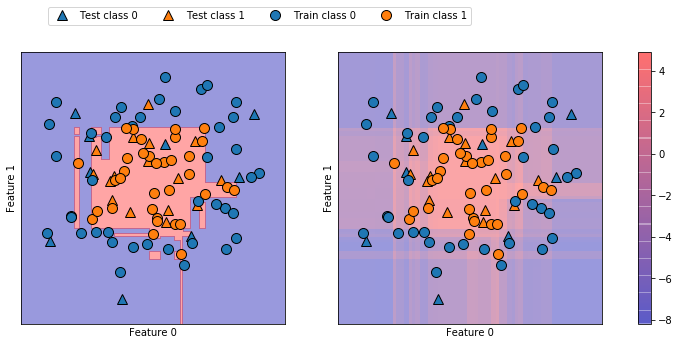

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

mglearn.tools.plot_2d_separator(gbrt, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(gbrt, X, ax=axes[1], alpha=.4, cm=mglearn.ReBl)

for ax in axes:
    # Plot training and test points
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test, markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
    
cbar = plt.colorbar(scores_image, ax=axes.tolist())
axes[0].legend(["Test class 0", "Test class 1", "Train class 0", "Train class 1"], ncol=4, loc=(.1, 1.1))